# Training the Discriminative Loss Function

In [1]:
# Import Dependencies

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
sys.path.append("../new_notebooks/ipynb/dlp_opendata_api")
sys.path.append("../new_notebooks/ipynb")

# DLP Open Data API, by Brad Nelson.
from osf.image_api import image_reader_3d
from osf.particle_api import *
from osf.cluster_api import *

from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Submanifold Sparse Convolutions, by Benjamin Graham
import sparseconvnet as scn

import glob
import os.path as osp
import numpy as np

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2,3"

TESTSET_SIZE = 32
DELTA_V = 0.5
DELTA_D = 1.5

Welcome to JupyROOT 6.14/04


## Check if GPU is available

In [2]:
#ls /gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10
use_cuda = torch.cuda.is_available()
print(use_cuda)
n_cuda = torch.cuda.device_count()
print(n_cuda)

True
2


## Define our Dataset and Dataloader

In [3]:
from model import UResNet, ClusteringMLP, get_unet
from utils import ClusteringAEData, ae_collate

In [4]:
root = '/gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10' #replace with your own path to root folder. 
trainset_cluster = [root + '/cluster/dlprod_cluster_192px_0{}.root'.format(i) for i in range(8)]
devset_cluster = [root + '/cluster/dlprod_cluster_192px_0{}.root'.format(8)]
#testset_cluster = [root + '/cluster/dlprod_cluster_192px_0{}.root'.format(9)]

trainset_energy = [root + '/dlprod_192px_0{}.root'.format(i) for i in range(8)]
devset_energy = [root + '/dlprod_192px_0{}.root'.format(8)]
#testset_energy = [root + '/dlprod_192px_0{}.root'.format(9)]

for i, f in enumerate(trainset_cluster):
    print(f)
    print(trainset_energy[i])
    
for i, f in enumerate(devset_cluster):
    print(f)
    print(devset_energy[i])
    
#for i, f in enumerate(testset_cluster):
#    print(f)
#    print(testset_energy[i])

trainset = ClusteringAEData(root, 192, filenames=[trainset_energy, trainset_cluster])
devset = ClusteringAEData(root, 192, filenames=[devset_energy, devset_cluster])
#testset = ClusteringAEData(root, 192, filenames=[testset_energy, testset_cluster])
print('Number of entries in training set: {}'.format(len(trainset)))
print('Number of entries in validation set: {}'.format(len(devset)))
#print('Number of entries in test set: {}'.format(len(testset)))

/gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10/cluster/dlprod_cluster_192px_00.root
/gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10/dlprod_192px_00.root
/gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10/cluster/dlprod_cluster_192px_01.root
/gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10/dlprod_192px_01.root
/gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10/cluster/dlprod_cluster_192px_02.root
/gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10/dlprod_192px_02.root
/gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10/cluster/dlprod_cluster_192px_03.root
/gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10/dlprod_192px_03.root
/gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10/cluster/dlprod_cluster_192px_04.root
/gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10/dlprod_192px_04.root
/gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10/cluster/dlprod_cluster_192px_05.root
/gpfs/slac/staas/fs1/g/n

In [5]:
trainloader = DataLoader(trainset, batch_size=16, shuffle=True, collate_fn=ae_collate, num_workers=8, pin_memory=False)
#devloader = DataLoader(devset, batch_size=1, shuffle=True, collate_fn=ae_collate, num_workers=0, pin_memory=False)

In [6]:
from utils import compute_accuracy, compute_accuracy_with_segmentation, save_checkpoint, load_checkpoint

## Get Sparse UResNet 

In [7]:
#fname = '/gpfs/slac/staas/fs1/g/neutrino/.scn_paper/new/sparse_is192_uns5_uf16_bs64/weights3/snapshot-29999.ckpt'
# The above file is the pre-trained weights of UResNet trained on semantic segmentation task.
# Owned by Laura Domine (Stanford, SLAC) and Terao Kazuhiro (SLAC)
#unet = get_unet(fname)
unet = UResNet(nFeatures=16, nClasses=2)
unet = unet.cuda()
#unet = unet.eval()

In [8]:
data, ins_label, seg_label = trainset[0]

In [9]:
import csv
f_train = open('train.csv', 'w')
trainWriter = csv.writer(f_train, delimiter=',')
f_dev = open('dev.csv', 'w')
devWriter = csv.writer(f_dev, delimiter=',')

In [10]:
training_epochs=100
#training_epoch=scn.checkpoint_restore(unet,exp_name,'unet',use_cuda)
optimizer = optim.Adam(unet.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
print('#classifer parameters', sum([x.nelement() for x in unet.parameters()]))

#load_checkpoint('checkpoint10.ckpt', unet, optimizer)

('#classifer parameters', 2741426)


## Random sample a small subset from the training and dev set

In [11]:
dev_index = list(np.random.randint(0, 9999, 32))
train_index = list(np.random.randint(0, 79999, 128))

sampler = torch.utils.data.sampler.SubsetRandomSampler(dev_index)
devloader = DataLoader(devset, sampler=sampler, batch_size=16, collate_fn=ae_collate)
sampler = torch.utils.data.sampler.SubsetRandomSampler(train_index)
train_small = DataLoader(trainset, sampler=sampler, batch_size=16, collate_fn=ae_collate)

## Import the Discriminative Loss nn.Module.

In [12]:
from loss import DiscriminativeLoss

In [13]:
criterion = DiscriminativeLoss(delta_var=DELTA_V, delta_dist=DELTA_D, multiclass=True, norm=2)

In [14]:
def test(model, devloader, finetune=None):
    model.eval()
    test_loss = 0
    test_acc = 0
    count = 0
    with torch.no_grad():
        for k, batch in enumerate(devloader):
            x_batch = batch[0]
            ins_labels = batch[1]
            seg_labels = batch[2]
            for j, data in enumerate(x_batch):
                out = model(data)
                loss = criterion(out, ins_labels[j], seg_labels=seg_labels[j])
                acc = compute_accuracy_with_segmentation(out, ins_labels[j], seg_labels[j])
                test_loss += loss
                test_acc += acc
                count += 1
    print("Testing Count = {}".format(count))
    return test_loss.item() / float(TESTSET_SIZE), test_acc / float(TESTSET_SIZE)

In [ ]:
import time

#trainset_len = len(trainset)
length = len(train_small.dataset)

for epoch in range(1, training_epochs+1):
    print("Epoch = {}".format(epoch))
    for i,batch in enumerate(train_small):
#        try:
        train_loss, train_acc = [], []
        unet.train()
        #model.train()
        optimizer.zero_grad()
        inputs, ins_labels, seg_labels = batch
        for j, data in enumerate(inputs):
            out = unet(data)
            loss = criterion(out, ins_labels[j], seg_labels=seg_labels[j])
            train_loss.append(loss)
            acc = compute_accuracy_with_segmentation(out, ins_labels[j], seg_labels[j])
            train_acc.append(acc)
        train_loss = sum(train_loss) / float(len(inputs))
        train_acc = sum(train_acc) / float(len(inputs))
        train_loss.backward()
        optimizer.step()
        print("Examples = {}/{}, Loss = {}, Acc = {}".format((i+1) * len(inputs), length, train_loss, train_acc))
        trainWriter.writerow([loss.item(), acc])
        f_train.flush()
        if i % 100 == 0:
            with torch.no_grad():
                dev_loss, dev_acc = test(unet, devloader)
                print("Devset Loss = {}, Acc = {}".format(dev_loss, dev_acc))
                devWriter.writerow([dev_loss, dev_acc])
                f_dev.flush()
    scheduler.step(train_loss)
#        except:
#            print("Warning: Error Encounterd!!")
#            continue
    if epoch % 10 == 0:
        save_checkpoint('checkpoint{}.ckpt'.format(epoch), unet, optimizer)
#scn.checkpoint_save(unet,exp_name,'unet',epoch, use_cuda)

## Visualizations

In [15]:
from localutil.data import *
from localutil.visualization import *
from plotly.offline import init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
#import plotly.io as pio

In [16]:
# Codes by Brad Nelson, I redefine the localutil.visualization modules 
# for better pictures (I set size of markers = 1)

def scatter_energy(img_reader, n, threshold=0.0):
    """
    Creates graph object for energy scatter plot
    Args:
        img_reader (image_reader_3d)
        n (int): image to plot
        threshold (optional): threshold energies below a certain value
    """
    voxels, energy, labels = img_reader.get_image(n)
    inds = energy > threshold
    trace = go.Scatter3d(x=voxels[inds,0], y=voxels[inds,1], z=voxels[inds,2],
                    mode='markers',
                    marker = dict(
                        size = 1,
                        color = np.log(energy[inds]),
                        colorscale='Viridis',
                        opacity=0.8
                    ), hovertext=energy)
    return trace

def scatter_classes(img_reader, n):
    voxels, types = img_reader.get_image(n)
    trace = go.Scatter3d(x=voxels[:,0], y=voxels[:,1], z=voxels[:,2],
                    mode='markers',
                    marker = dict(
                        size = 1,
                        color = types,
                        colorscale='Viridis',
                        opacity=0.8
                    ), hovertext=types)
    return trace

def scatter_clusters(voxels, clusters):
    trace = go.Scatter3d(x=voxels[:,0], y=voxels[:,1], z=voxels[:,2],
                    mode='markers',
                    marker = dict(
                        size = 1,
                        color = clusters,
                        colorscale='Viridis',
                        opacity=0.8
                    ), hovertext=clusters)
    return trace

In [17]:
import matplotlib

In [18]:
# 22772 for good eventexample
eventn = 22772
trace1 = scatter_classes(trainset.cluster_reader, eventn)
trace2 = scatter_energy(trainset.energy_reader, eventn)
fig = go.Figure(data=[trace1])
iplot(fig)
#pio.write_image(fig, 'images/fig1.pdf')

In [19]:
data, clabel, slabel = trainset[22772]

In [49]:
load_checkpoint('checkpoint70.ckpt', unet, optimizer)
unet = unet.eval()
embed = unet(data)

model loaded from checkpoint70.ckpt


In [50]:
semantic_classes = slabel.unique()
semantic_classes

tensor([3, 1, 2])

In [51]:
cluster_labels = clabel.unique()
cluster_labels

tensor([ 8, 28,  1, 11, 33,  3, 12,  0, 21, 30, 13])

In [52]:
coords = embed.cpu().detach().numpy()

In [53]:
x = coords[:, 0]
y = coords[:, 1]
z = clabel.numpy()
z = z.squeeze()

In [54]:
index = (slabel == 1).squeeze(1).nonzero()
index = index.squeeze(1)
embedding_c, truth_c = embed[index], clabel[index]

In [55]:
acc, clusters = compute_accuracy(embedding_c, truth_c)
print(acc)

0.855913525965


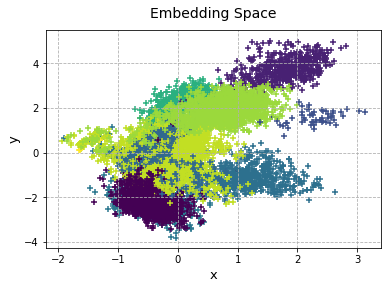

In [56]:
#colors = ['navy','purple','yellow']
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.scatter(x,y, c=z, cmap=matplotlib.pyplot.viridis(), marker='+', alpha=1)
ax.set_xlabel('x', fontsize=13)
ax.set_ylabel('y', fontsize=13)
ax.set_title('Embedding Space'.format(acc), y=1.03, fontsize=14)
plt.show()
plt.close()

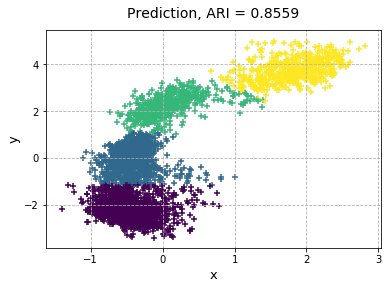

In [59]:
#colors = ['navy','purple','yellow']
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.scatter(x[index],y[index], c=clusters, cmap=matplotlib.pyplot.viridis(), marker='+', alpha=1)
ax.set_xlabel('x', fontsize=13)
ax.set_ylabel('y', fontsize=13)
ax.set_title('Prediction, ARI = {:.4f}'.format(acc), y=1.03, fontsize=14)
plt.show()
plt.close()
# The plots look slightly different from the ones in the project, since
# the examples in the project report was trained for 2~3 epochs more than
# the current checkpoint.

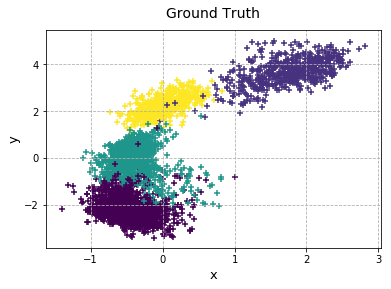

In [58]:
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.scatter(x[index],y[index], c=z[index], cmap=matplotlib.pyplot.viridis(), marker='+', alpha=1)
ax.set_xlabel('x', fontsize=13)
ax.set_ylabel('y', fontsize=13)
ax.set_title('Ground Truth'.format(acc), y=1.03, fontsize=14)
plt.show()
plt.close()